In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy


def read_arduino_2ch_binary(number_readings=1, data_type=numpy.float32, error_value=numpy.NaN, 
                 serial_port='COM3', baud_rate=115200, timeout=2, delay=228,
                 startup_message='Yours sincerely, Arduino'): 
    '''
    Returns number_readings (default 1) voltage measurements as binary data from Arduino 
    attached to serial_port at baud_rate with specified timeout.
    Arduino should give a suitable startup message (string).  
    Returns a numpy array of shape (2, number_readings), of type data_type, and a numpy
    array of timestamps of same shape and type numpy.float32. 
    Returns element with error_value if value cannot be converted to type data_type, but
    attempts to correct timestamp array for errors.
    '''
    if number_readings < 1: number_readings = 1 
    numeric_values = numpy.zeros((2, number_readings), dtype=data_type) 
    time_diffs = numpy.zeros((number_readings,), dtype=data_type) 
    
    import serial
    with serial.Serial(port=serial_port, baudrate=baud_rate, timeout=timeout) as arduino:
        arduino.read_until(startup_message.encode()) 
        for i in range(number_readings):
            binary_data = arduino.read(size=6) 
            try: 
                numeric_values[0, i] = data_type((binary_data[0] + (binary_data[1]*2**8))*5/1023) 
                numeric_values[1, i] = data_type((binary_data[2] + (binary_data[3]*2**8))*5/1023) 
                time_diffs[i] = data_type(binary_data[4] + (binary_data[5]*2**8)) 
            except (ValueError, IndexError):
                numeric_values[0, i] = error_value
                numeric_values[1, i] = error_value
                time_diffs[i] = 0
    
    timestamps = reconstruct_timestamps(time_diffs, 2, delay)
    
    return numeric_values, timestamps*1e-6


def reconstruct_timestamps(diffs, n_channels, delay=228):
    '''
    More robust reconstruction of corrected timestamp array: any zero values
    in 'diffs' due to errors are replaced with the modal value of the rest
    of the array, before making the cumulative sum.
    '''
    from scipy.stats import mode
    try: # Determine the most common (mode) of the valid time_diff values
        mode_diff = mode(diffs[diffs != 0]).mode[0]     
    except IndexError: # If ALL diffs are zero, due to errors, mode.mode = []
        print('Your Arduino sketch is not compatible with this function!')
        mode_diff = 0 #  This will still return array of zeros for timestamps
        
    timestamps = numpy.where(diffs == 0, # replace invalid values
                             mode_diff, # with most common valid value
                             diffs).cumsum() # then take cumulative sum
    return numpy.array([timestamps + i*delay for i in range(n_channels)])


def read_and_discard(number_to_read=1, number_to_discard=100, **kwds):
    '''
    Returns number_to_read (default 1) samples from Arduino by binary transfer, 
    after discarding the first number_to_discard samples (default 100).
    Other arguments passed using **kwds.
    '''
    kwds.pop('number_readings', None) 
    sigs, time = read_arduino_2ch_binary(number_readings=number_to_read+number_to_discard, **kwds)
    return sigs[:, number_to_discard:], time[:, number_to_discard:]

def plot_signals(signals, times, plot=True):
    '''Plots a graph of the 2D numpy array 'signals' of
    two-channel data, vs times array of same shape, if plot=True.'''
    if plot: # only plot graph if plot=True
        plt.figure(figsize=(10,2))
        plt.plot(times[0], signals[0], 'b', label='A0')
        plt.plot(times[1], signals[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('time (s)'); plt.ylabel('ADC voltage (V)')
        plt.show()
        
def FFT(signals, times, plot=True):
    '''
    Determine and plot (positive frequency) FFT, and from these 
    determine the phase-shift between 2 datasets using 
    cross-correlation from Fast Fourier Transforms.
    signals and times are arrays of the same shape, providing a
    timestamp for each signal. 
    Returns arrays of frequencies and amplitudes of (non-zero frequency) 
    fundamental tone, and the phase shift between the signals.
    '''   
    from scipy.fftpack import fft, ifft
    from scipy.signal import argrelmax, argrelmin
    
    ffts = fft(signals) # Only calculate this once, it does all arrays together! 
    yf = 2.0/len(signals[0]) * numpy.abs(ffts[:, :len(signals[0])//2])[:, 1:] 
    xf = numpy.linspace(0.0, 
                        len(times[0])/(2.0*(times[0,-1]-times[0,0])), 
                        len(times[0])//2)[1:]
    freq = xf[numpy.argmax(yf, axis=1)]
    amp = numpy.max(yf, axis=1) 
    angle = 360*freq[0]*(times - times[0,0]) 
    angle = angle[0] - angle[1,0] 
    correlation = ifft(ffts[0] * ffts[1].conj()).real 
    try:
        phase = angle[argrelmax(correlation)[0][0]] % 360 
        phase_err = 2 * abs(angle[1]-angle[0]) / numpy.sqrt(len(argrelmax(correlation)[0]))
    except IndexError: # no maxima in correlation
        phase = 0
        phase_err = 0
    
    if plot:
        plt.figure(figsize=(10,4))
        plt.subplot(211)
        plt.plot(xf, yf[0], 'b', label='A0')
        plt.plot(xf, yf[1], 'r', label='A1')
        plt.legend()
        plt.xlabel('Frequency (Hz)'); plt.ylabel('Amplitude')
              
        plt.subplot(223)
        plt.plot(angle, correlation)
        plt.xlabel('angle (degrees)'); plt.ylabel('cross-correlation')
        
        plt.subplot(224)
        try:
            length = argrelmin(correlation)[0][1]
        except IndexError: # no minima in correlation
            length = -1 # plot all of data
        plt.plot(angle[:length], correlation[:length], marker='o')
        plt.xlabel('angle (degrees)')
        
        plt.tight_layout()
        plt.show()
        
        print('Ch0: Fundamental frequency at {}, with amplitude {}.'.format(freq[0], amp[0]))
        print('Ch1: Fundamental frequency at {}, with amplitude {}.'.format(freq[1], amp[1]))
        print('Nyquist frequency as last point in FFT = {}'.format(xf[-1]))
        print('Phase-shift = {} +/- {}'.format(phase, phase_err))
        
    return freq, amp, (phase, phase_err)

def frequency_sweep(freqs, number_readings=2000, duration=3, plot=False):
    import simpleaudio as sa
    # set up arrays for signal data
    sample_rate = 44100 
    samples = int(duration)*sample_rate
    time = numpy.linspace(0, int(duration), samples, False)
    # set up arrays for measurement data
    fft_freqs = numpy.zeros((len(freqs), 2), dtype=numpy.float32) 
    amplitudes = numpy.zeros_like(fft_freqs) 
    phase = numpy.zeros_like(fft_freqs) 
    
    for i, freq in enumerate(freqs): # loop over listed frequencies
        if plot: print('\n', freq, 'Hz')
        # generate and play audio signals
        audio = numpy.zeros((samples, 2))
        audio[:,0] = 1 + numpy.sin(2*numpy.pi*freq*time) # 'left' - sine
        audio[:,1] = 1 + numpy.cos(2*numpy.pi*freq*time) # 'right' - cosine
        audio *= 32767 / numpy.max(numpy.abs(audio)) # normalize to 16-bit
        audio = audio.astype(numpy.int16) # convert to 16-bit datatype
        play_obj = sa.play_buffer(audio, 2, 2, sample_rate) # start playback
        # acquire measurement from Arduino
        signal, times = read_and_discard(number_to_read=number_readings, delay=228)
        # plot and process acquired signals
        plot_signals(signal, times, plot)
        fft_freqs[i], amplitudes[i], phase[i] =  FFT(signal, times, plot)
        # wait for playback to finish before continuing
        play_obj.wait_done() 
        
    return fft_freqs.T, amplitudes.T, phase.T

def plot_sweep(freqs, amplitudes, phase):
        
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot(211)
    plt.plot(freqs[0], amplitudes[0], 'b', label='A0') # could use errorbar...
    plt.plot(freqs[1], amplitudes[1], 'r', label='A1') 
    plt.xscale('log'); plt.grid(which='both', axis='both')               
    plt.ylabel('FFT amplitude (V)'); plt.legend()

    ax2 = plt.subplot(212, sharex=ax1)
    phases = ((phase[0] + 180) % 360) - 180 # shift into range +/- 180
    plt.errorbar(freqs[0], phases, yerr=phase[1]) 
    plt.ylim(-180, 180); plt.yticks(ticks=[-180, -90, 0, 90, 180])
    plt.xscale('log');     plt.grid(which='both', axis='both')               
    plt.xlabel('FFT frequency (Hz)'); plt.ylabel('Phase-shift (degrees)')

    plt.setp(ax1.get_xticklabels(), visible=False)
    fig.align_ylabels()
    plt.tight_layout()
    plt.show()
    
def decibel_gain(v_in, v_out, v_in_errs=None, v_out_errs=None):
    '''
    Uses 20-log rule to determine dB gains from arrays of 
    input- and output-voltages. 
    dB gain errors are also calculated and returned if voltage 
    errors are specified, otherwise 'None' is returned.
    '''
    # Calculate voltage gain: ratio of output to input voltages
    v_gains = v_out/v_in # [dimensionless] 
    # Calculate dB gain using the '20-log' rule
    dB_gains = 20*numpy.log10(numpy.abs(v_gains)) # [dB]
    
    errs = False # do we have errors supplied?
    if v_in_errs is not None:
        errs = True # yes we do!
    else: # possibly not - set to zero incase we need to calculate.
        v_in_errs = numpy.zeros_like(v_in)
    
    if v_out_errs is not None:
        errs = True # yes we do!
    else: #  possibly not - set to zero incase we need to calculate.
        v_out_errs = numpy.zeros_like(v_out)
    
    if errs: # at least one voltage has errors supplied, zero if not supplied
        # Calculate voltage gain error: quadrature sum of voltage errors
        v_gain_errs = v_gains*numpy.sqrt((v_in_errs/v_in)**2 
                                         + (v_out_errs/v_out)**2) # [dimensionless] 
        # Calculate dB gain error: error-propagation based on 20-log rule, 
        # see inside front cover of Hughes & Hase! 
        dB_gain_errs = 20*v_gain_errs/(numpy.log(10)*v_gains) # [dB]
        return dB_gains, dB_gain_errs
    # otherwise...
    return dB_gains, None # Both matplotlib and curve_fit handle 'None'.


def gain_bode_plot(freqs, dB_gains, dB_gain_errs=None):
    '''
    Bode plot for gain. Inputs are numpy arrays containing: 
    frequencies in Hz
    gains in dB
    gain errors in dB (or 'None')
    '''
    # Plot the figure: Bode plot is dB gain as a function of frequency, 
    # with frequency plotted on a log_10 scale. 
    fig = plt.figure(figsize=(6,3))
    plt.errorbar(freqs,                 # Errorbar plot: x axis is Frequency [Hz]
                 dB_gains,              # y axis is dB_gain [dB]
                 yerr=dB_gain_errs,     # error-bars on y axis [dB]
                 marker='o',            # round, unfilled markers 
                 fillstyle='none', 
                 color='blue',          # markers and errorbars same colour for clarity
                 ecolor='blue', 
                 linestyle='none')      # Do NOT show connecting lines between datapoints!
    plt.xscale('log', base=10)          # log10 scale for x axis ('basex' for older versions)
    plt.yscale('linear')                # explicitly set (default) linear scale for y axis
    plt.grid(which='both',              # gridlines for both 'major' and 'minor' tick labels
             axis='both')               # gridlines for both 'x' and 'y' axes      
    plt.title('Gain Bode Plot')         # Title
    plt.xlabel('Frequency (Hz)')        # Axis labels
    plt.ylabel('Gain (dB)')            
    # We will need to call 'plt.show()' afterwards... 


def phase_bode_plot(freqs, phase_shifts, phase_shift_errs=None):
    '''
    Bode plot for phase shift. Inputs are numpy arrays containing: 
    frequencies in Hz
    phase-shifts in degrees
    phase-shift errors in degrees
    '''    
    phase_shifts = ((phase_shifts + 180) % 360) - 180 # shift into range +/- 180
    # Plot the figure: Bode plot is phase angle as a function of frequency, 
    # with frequency again plotted on a log_10 scale.
    fig = plt.figure(figsize=(6,3))
    plt.errorbar(freqs,                  # Errorbar plot: x axis is Frequency [Hz]
                 phase_shifts,           # y axis is Phase shift [degrees]
                 yerr=phase_shift_errs,  # error-bars on y axis [degrees]
                 marker='o',             # round, unfilled markers 
                 fillstyle='none', 
                 color='blue',           # markers and errorbars same colour for clarity
                 ecolor='blue', 
                 linestyle='none')       # Do NOT show connecting lines between datapoints!
    plt.xscale('log', base=10)           # log10 scale for x axis ('basex' for older versions)
    plt.yscale('linear')                 # explicitly set (default) linear scale for y axis
    plt.grid(which='both',               #gridlines for both 'major' and 'minor' tick labels
             axis='both')                #gridlines for both axes      
    plt.title('Phase Bode Plot')         # Title
    plt.xlabel('Frequency (Hz)')         # Axis labels
    plt.ylabel('Phase angle (degrees)')
    # We will need to call 'plt.show()' afterwards... 

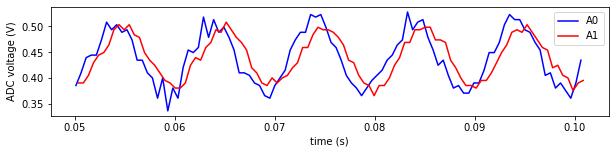

In [5]:
plot_signals(*read_and_discard(number_to_read=100)) # 100

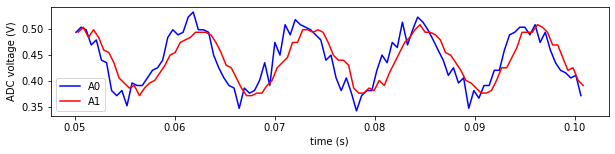

In [4]:
plot_signals(*read_and_discard(number_to_read=100)) #88

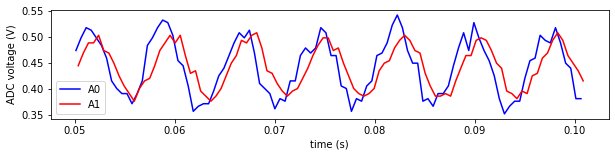

In [6]:
plot_signals(*read_and_discard(number_to_read=100)) #130

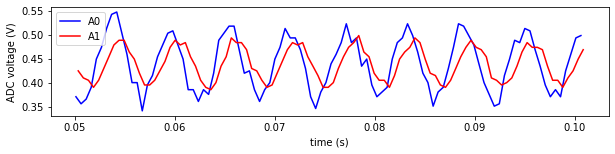

In [7]:
plot_signals(*read_and_discard(number_to_read=100)) #170

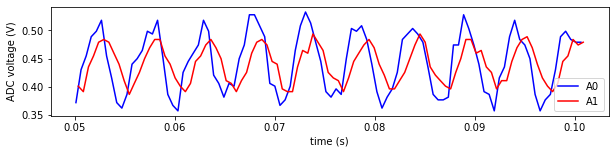

In [8]:
plot_signals(*read_and_discard(number_to_read=100)) #190

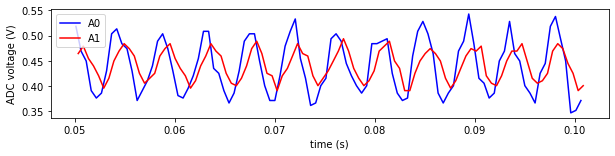

In [9]:
plot_signals(*read_and_discard(number_to_read=100)) #230